In [169]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Step 1: Background

## Step 2: Fetch Stock Data for Multiple Companies

In [26]:
# List of stock symbols you want to analyze
stocks = ["NVDA", "AVGO", "AMD", "CSCO", "MRVL"]

# Fetch historical data for all stocks
data = yf.download(stocks, start="2023-01-01", end="2023-12-31")

[*********************100%***********************]  5 of 5 completed


## Step 3: Data Manipulation

### Closing Price Overview

In [29]:
# Extract closing prices
closing_prices = data['Adj Close']

In [31]:
closing_prices.head()

Ticker,AMD,AVGO,CSCO,MRVL,NVDA
Date,,,,,
2023-01-03 00:00:00+00:00,64.019997,53.716278,45.392155,35.703835,14.305581
2023-01-04 00:00:00+00:00,64.660004,54.372349,45.382607,36.318905,14.739295
2023-01-05 00:00:00+00:00,62.330002,53.865742,44.743149,34.460732,14.255614
2023-01-06 00:00:00+00:00,63.959999,57.108242,46.117508,35.871750,14.849224
2023-01-09 00:00:00+00:00,67.239998,55.988266,46.365658,36.686565,15.617718


## Step 4: Perform Comparative Analysis

### 4.1 Calculate Moving Averages(MA)

In [276]:
def fetch_data(ticker, period="1y"):
    """
    Fetch historical stock data for a given ticker and period.
    
    Args:
    - ticker (str): The stock ticker symbol.
    - period (str): Duration of the historical data (e.g., "1y" for one year).
    
    Returns:
    - DataFrame: A DataFrame with historical stock data.
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    return data

def calculate_moving_averages(data, short_window=50, long_window=200):
    """
    Calculate short-term and long-term moving averages.
    
    Args:
    - data (DataFrame): Stock data.
    - short_window (int): Window size for the short-term moving average.
    - long_window (int): Window size for the long-term moving average.
    
    Returns:
    - data (DataFrame): Modified DataFrame including new columns for moving averages.
    """
    data['50_MA'] = data['Close'].rolling(window=short_window).mean()
    data['200_MA'] = data['Close'].rolling(window=long_window).mean()
    return data

def plot_stock(data, title):
    """
    Plot stock close prices along with moving averages.
    
    Args:
    - data (DataFrame): Stock data with moving averages.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['50_MA'], label='50-Day MA')
    plt.plot(data['200_MA'], label='200-Day MA')
    plt.title(title)
    plt.legend()
    plt.show()

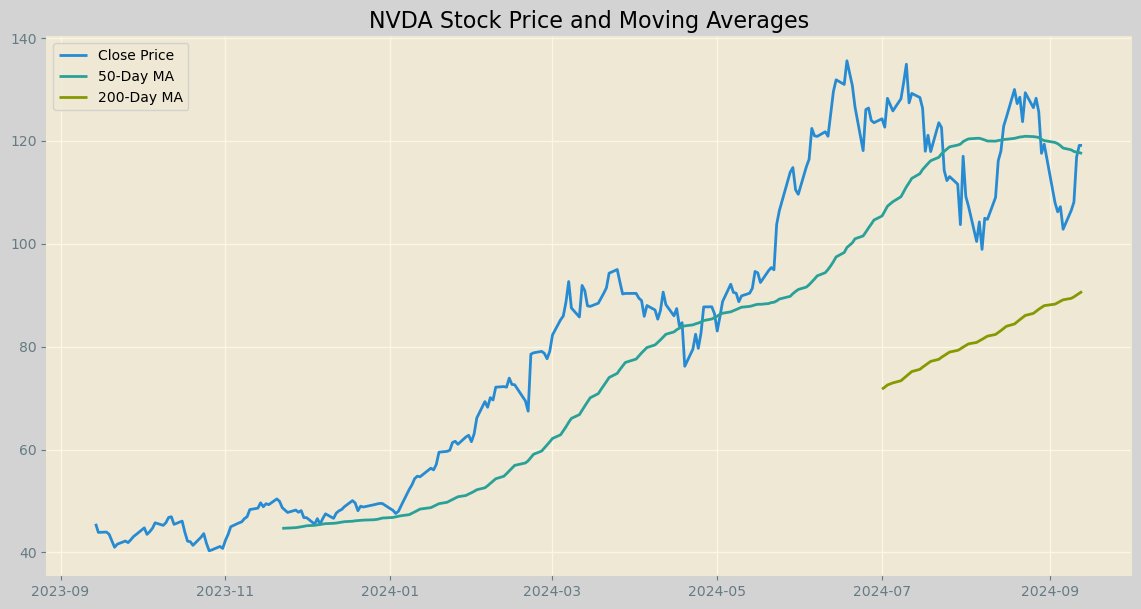

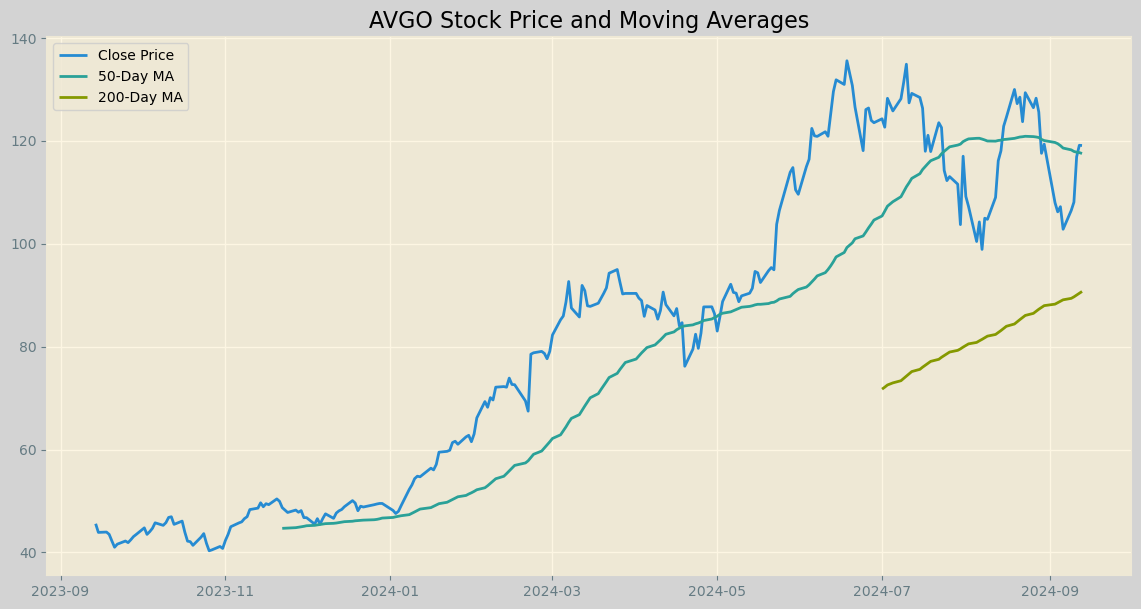

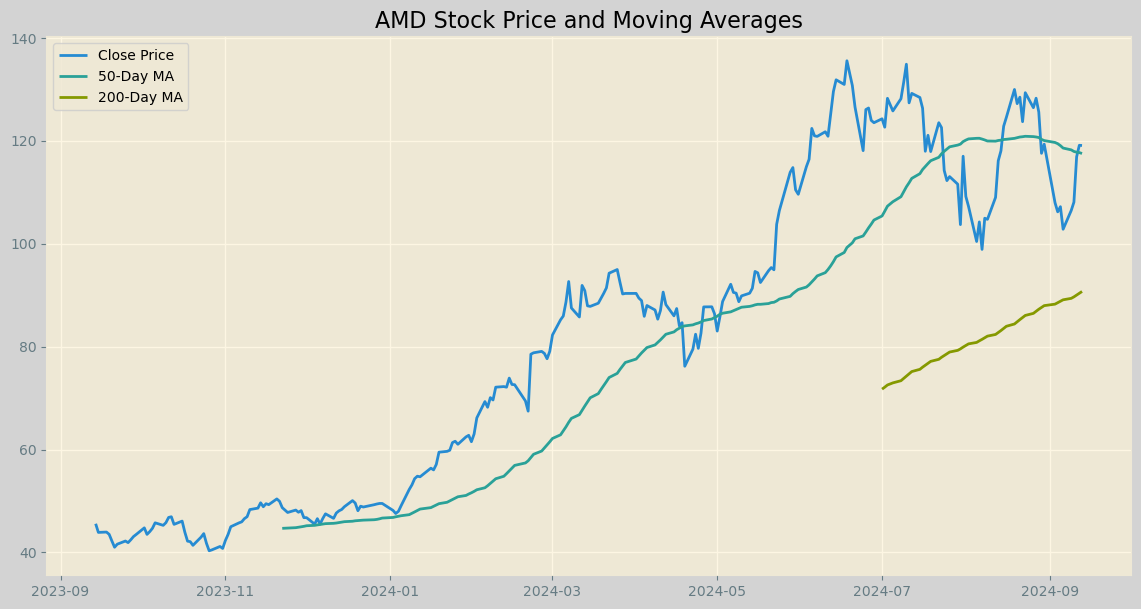

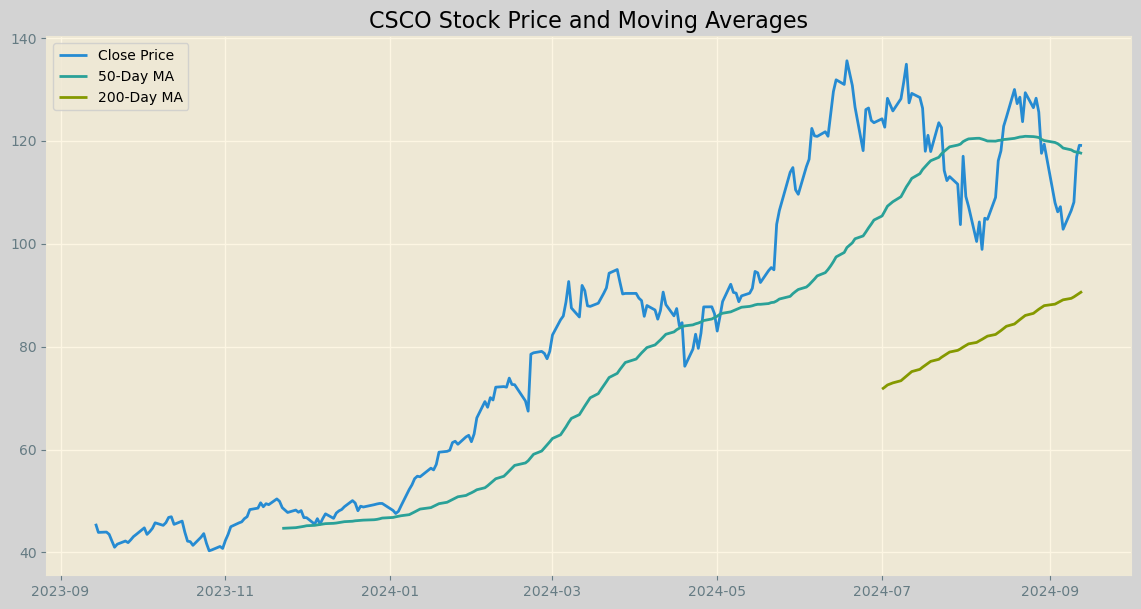

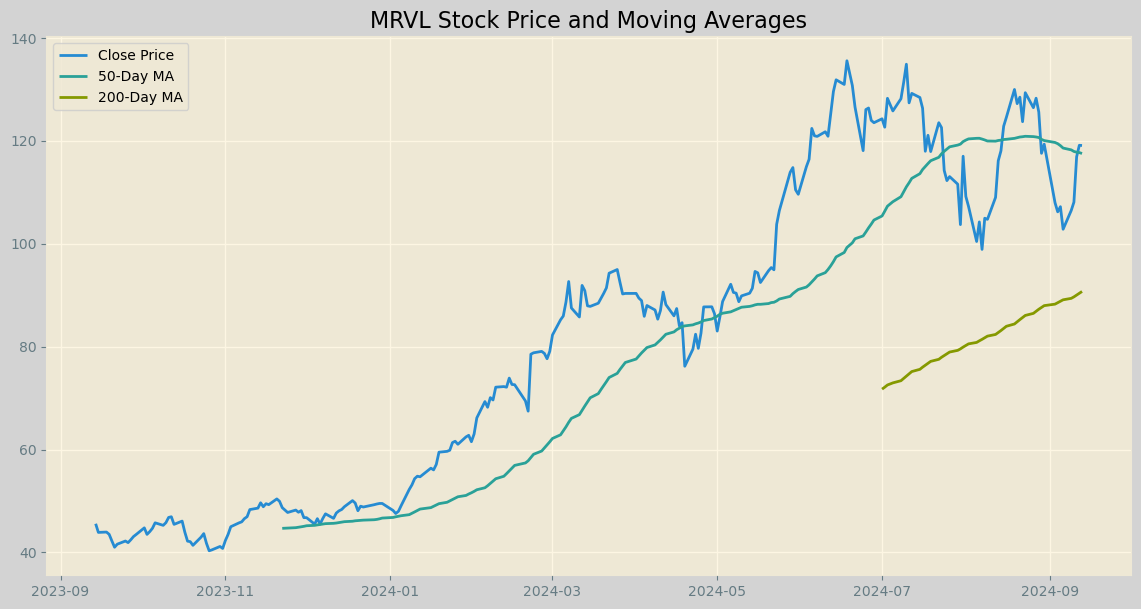

In [278]:
for stock in stocks:
    base_data = fetch_data(stock)
    ma_data = calculate_moving_averages(data)
    plot_title = f'{stock} Stock Price and Moving Averages'
    plot_stock(ma_data, plot_title)

### 4.2 Calculate and Compare Returns

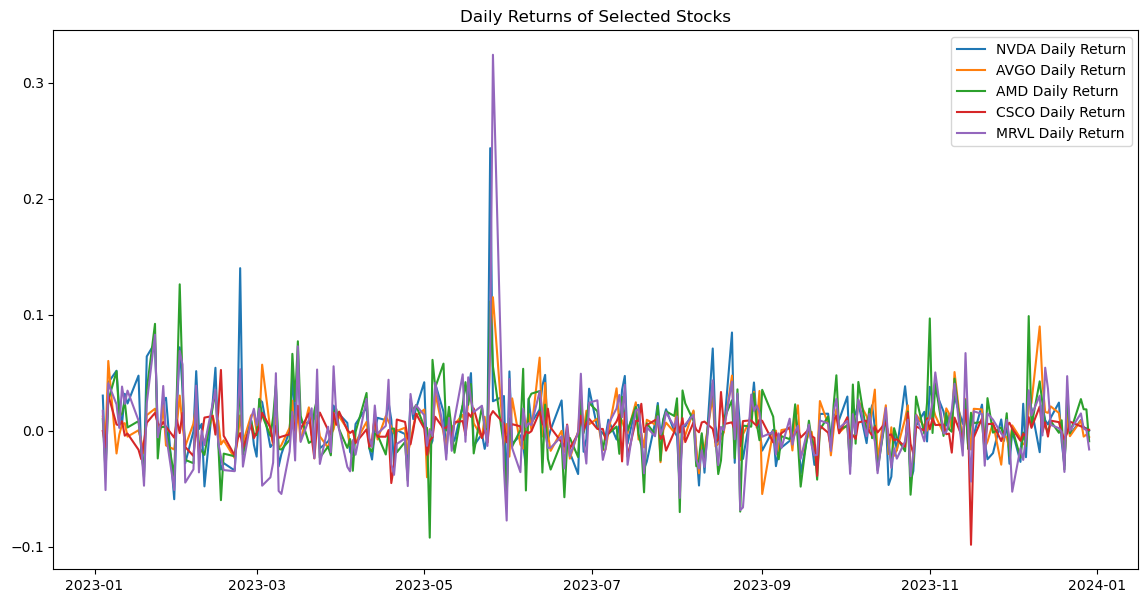

In [41]:
# Daily returns
daily_returns = closing_prices.pct_change()

# Plot daily returns
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(daily_returns[stock], label=f'{stock} Daily Return')

plt.title('Daily Returns of Selected Stocks')
plt.legend()
plt.show()

### 4.3 Calculate MACD & Signal Line

- **Explain MACD**
    - MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 
    - The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. 
    - The result of that calculation are 
        - MACD line 
        - Signal line: A nine-day EMA of the MACD => can function as a trigger for buy and sell signals.


- **Analysis Methodology**
    - Look for Crossovers: 
        - A crossover of the MACD line above the signal line suggests a potential buy signal. 
        - Conversely, a crossover below might suggest a sell.
    - Consider Divergence: 
        - If the price of a stock is making new highs while the MACD is failing to reach new highs, this could indicate a possible reversal.
    - Zero Crossings: 
        - When the MACD line crosses above zero, it suggests a bullish condition, and crossing below zero suggests bearish.

In [76]:
def MACD(DF, a=12, b=26, c=9):
    """Function to calculate MACD for multiple stocks
       typical values a = 12; b =26, c =9"""
    
    df = DF.copy()
    macd = pd.DataFrame()
    signal = pd.DataFrame()
    
    for stock in df.columns:
        # Calculate the fast and slow EMAs
        df_fast_ema = df[stock].ewm(span=a, adjust=False).mean()
        df_slow_ema = df[stock].ewm(span=b, adjust=False).mean()
        
        # Calculate the MACD and Signal lines
        macd[stock] = df_fast_ema - df_slow_ema
        signal[stock] = macd[stock].ewm(span=c, adjust=False).mean()
        
    return macd, signal

In [78]:
macd, signal = MACD(closing_prices)

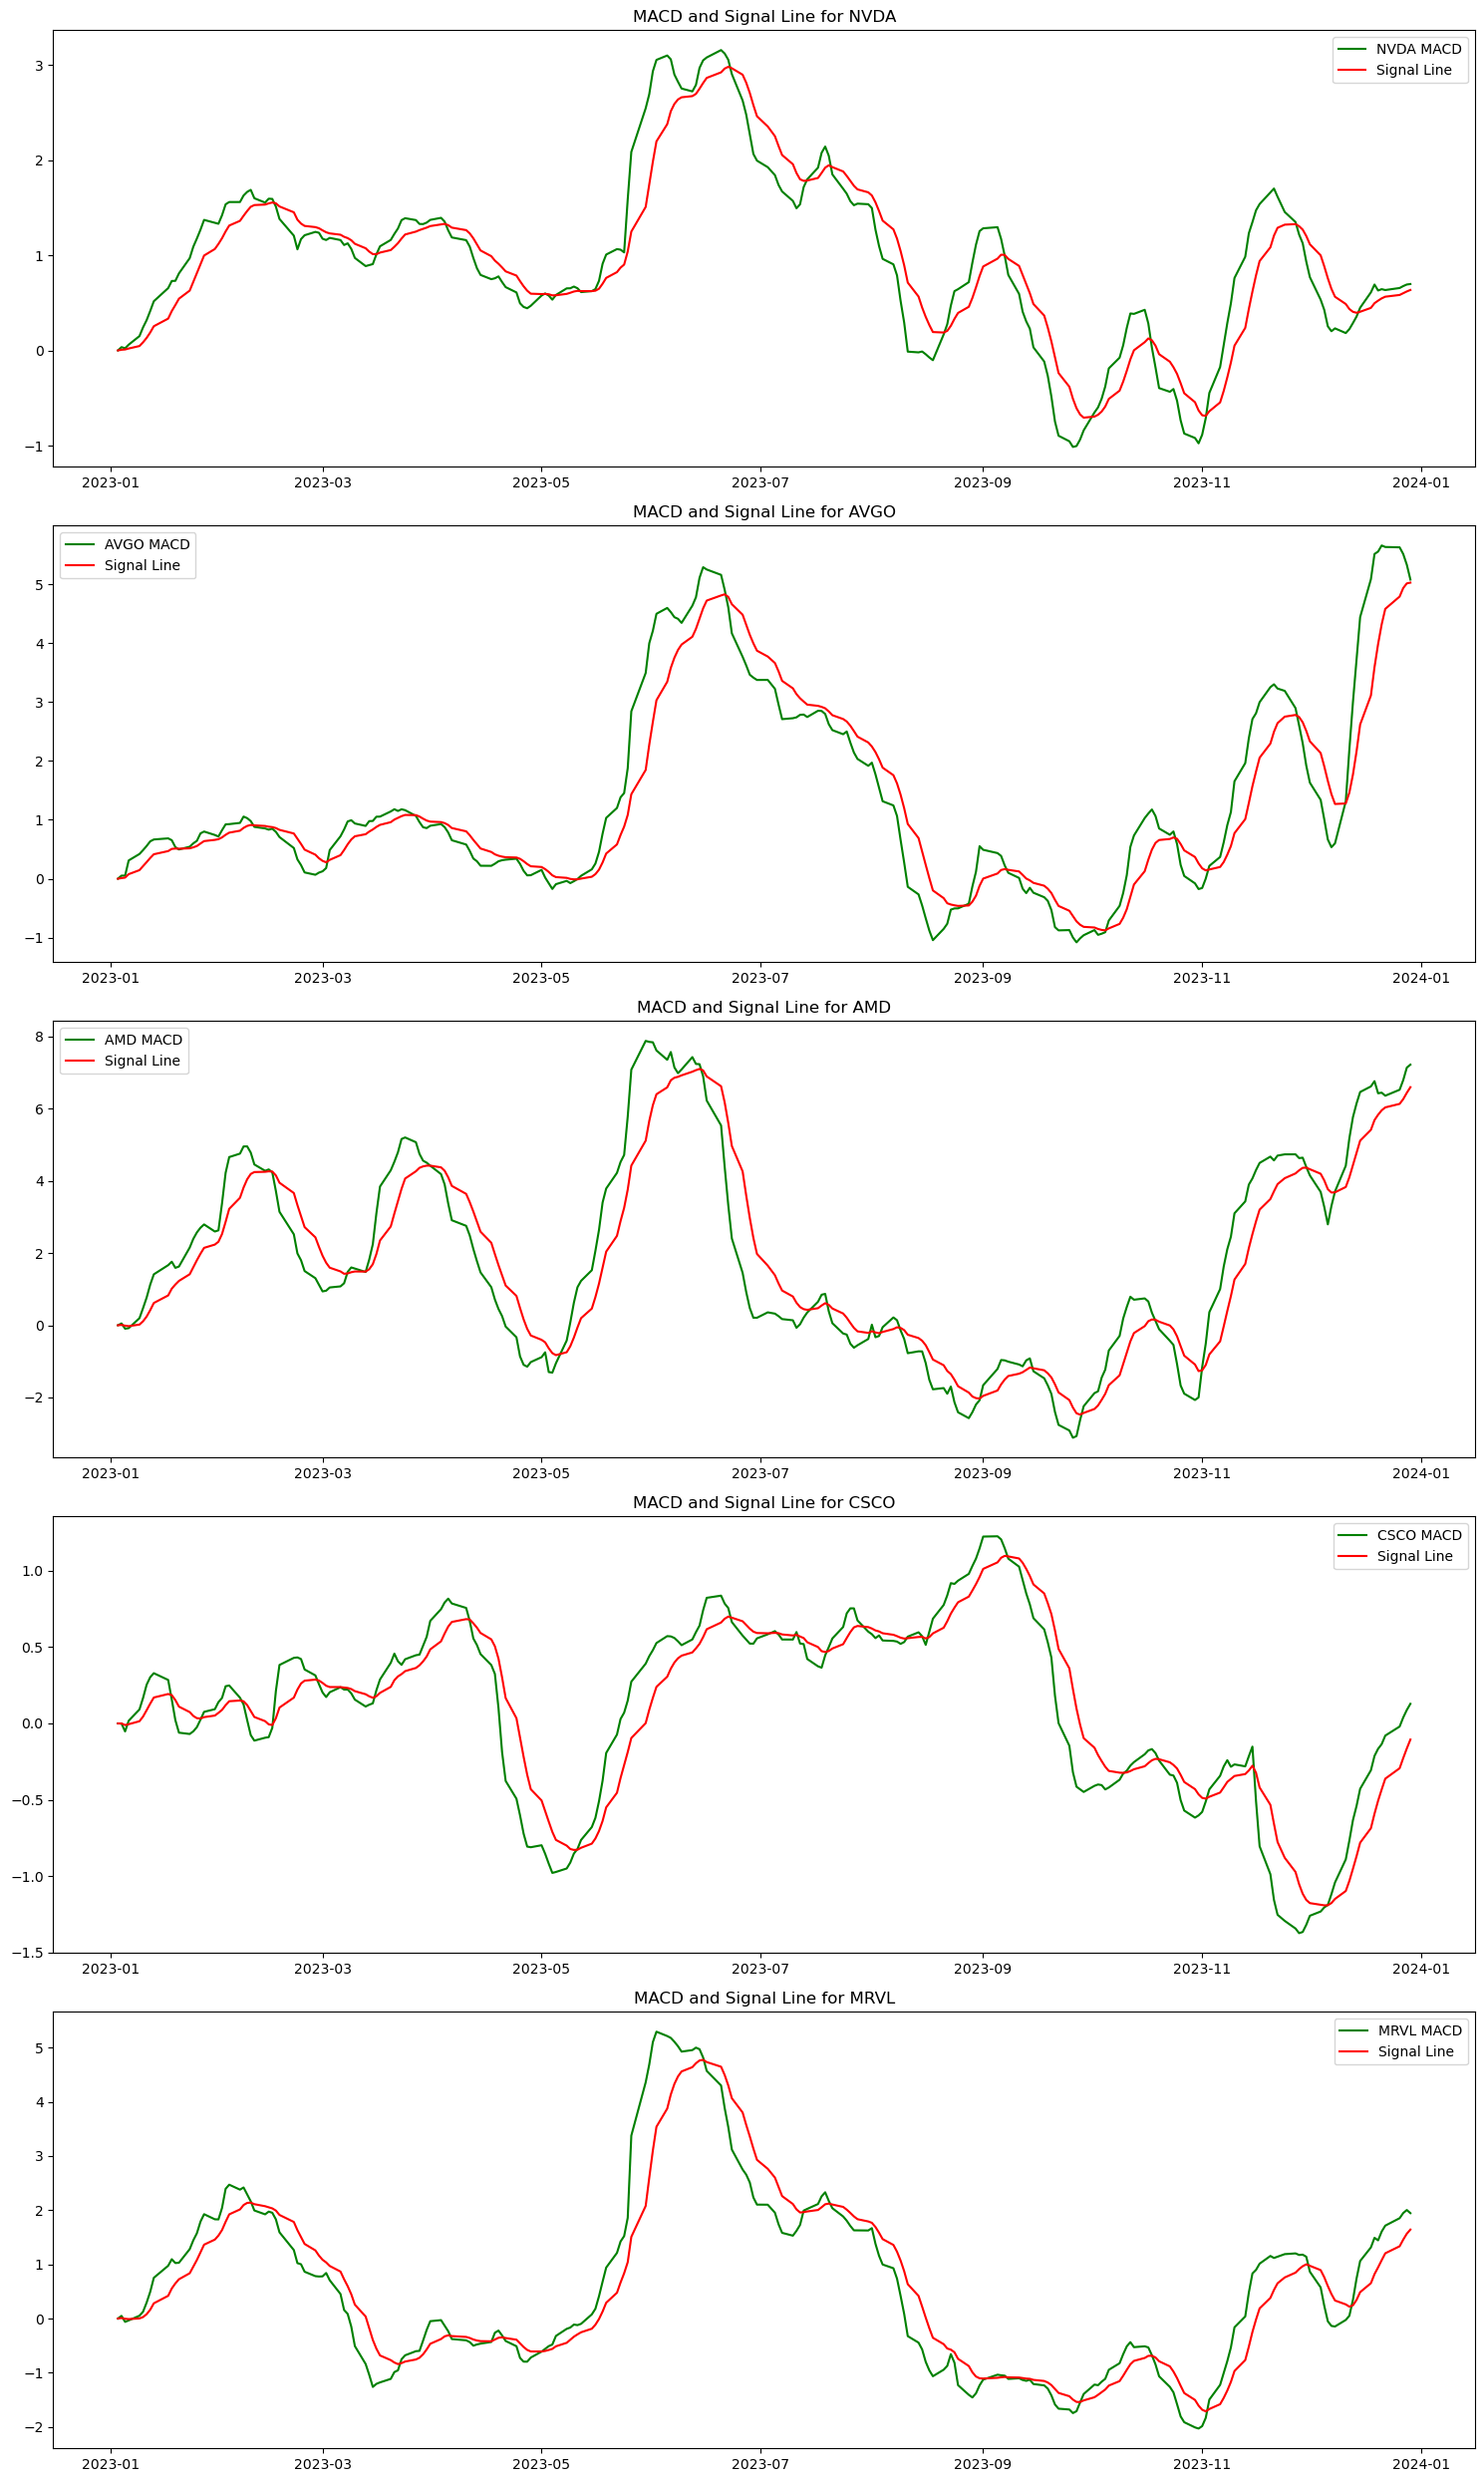

In [80]:
# Number of subplots
num_stocks = len(stocks)
plt.figure(figsize=(15, num_stocks * 5))

for i, stock in enumerate(stocks, 1):
    plt.subplot(num_stocks, 1, i)
    plt.plot(macd.index, macd[stock], label=f'{stock} MACD', color='green')
    plt.plot(signal.index, signal[stock], label='Signal Line', color='red')
    plt.title(f'MACD and Signal Line for {stock}')
    plt.legend()

plt.tight_layout()
plt.show()

### 4.4 Risk Analysis - Volatility

In [46]:
# Annualized Volatility
annual_volatility = daily_returns.std() * (252**0.5)  # Assuming 252 trading days in a year

print("Annualized Volatility:")
print(annual_volatility)

Annualized Volatility:
Ticker
AMD     0.469396
AVGO    0.321670
CSCO    0.203884
MRVL    0.548646
NVDA    0.484566
dtype: float64


### 4.5 Correlation Analysis

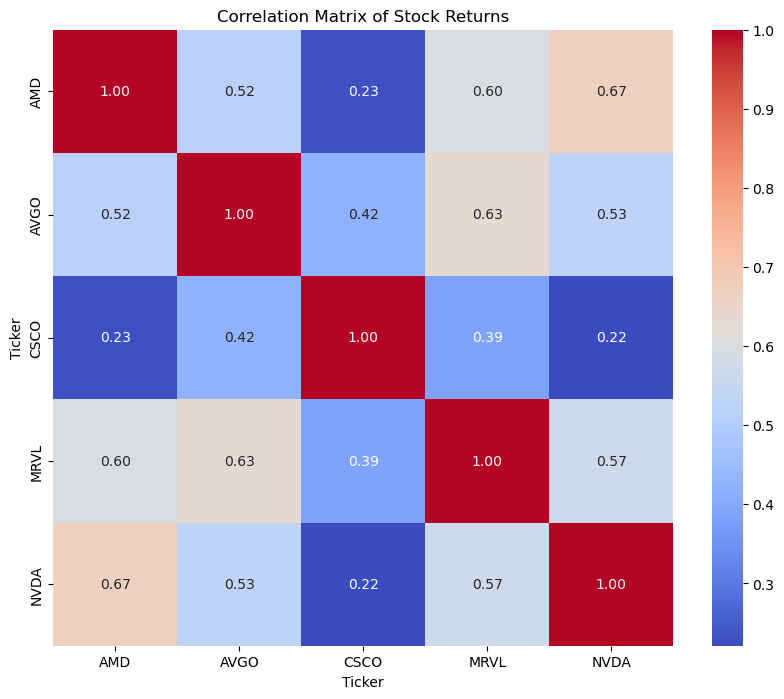

In [49]:
# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Visualize the correlation matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Returns')
plt.show()

### 4.6 ATR & Bollinger Bands

**Goal: assess volatility and potential price movements**
- Average True Range (ATR)
    - The ATR measures market volatility by decomposing the entire range of an asset price for that period. 
    - It's particularly useful for setting stop-loss orders or for determining entry and exit points.
- Bollinger Bands
    - Bollinger Bands consist of a middle band being an N-period simple moving average (SMA), an upper band at K times an N-period standard deviation above the middle band a lower band at K times an N-period standard deviation below the middle band. 
    - They help in identifying the highness or lowness of the price relative to previous trades.




In [122]:
def ATR(DF, n=14):
    """Calculate the Average True Range (ATR) for given data."""
    df = DF.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift())
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift())
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(n).mean()
    return df['ATR']

def Bollinger_Bands(DF, n=20, k=2):
    """Calculate Bollinger Bands for given data."""
    df = DF.copy()
    df['MA'] = df['Adj Close'].rolling(window=n).mean()
    df['BB_up'] = df['MA'] + k * df['Adj Close'].rolling(window=n).std()
    df['BB_down'] = df['MA'] - k * df['Adj Close'].rolling(window=n).std()
    return df['MA'], df['BB_up'], df['BB_down']

In [151]:
def calculate_indicators(data, stocks):
    atr_results = {}
    bb_results = {}
    
    for stock in stocks:
        # Access MultiIndex correctly by specifying both level values
        df = pd.DataFrame({
            'High': data[('High', stock)],
            'Low': data[('Low', stock)],
            'Close': data[('Adj Close', stock)],
            'Adj Close': data[('Adj Close', stock)]
        })
        print(df)
        # Calculate indicators
        atr_results[stock] = ATR(df, n=14) 
        ma, bb_up, bb_down = Bollinger_Bands(df, n=20, k=2) 
        bb_results[stock] = (ma, bb_up, bb_down)
    
    return atr_results, bb_results

In [161]:
atrs, bollinger_bands = calculate_indicators(data, stocks)

                                High        Low      Close  Adj Close
Date                                                                 
2023-01-03 00:00:00+00:00  14.996000  14.096000  14.305581  14.305581
2023-01-04 00:00:00+00:00  14.853000  14.241000  14.739295  14.739295
2023-01-05 00:00:00+00:00  14.564000  14.148000  14.255614  14.255614
2023-01-06 00:00:00+00:00  15.010000  14.034000  14.849224  14.849224
2023-01-09 00:00:00+00:00  16.056000  15.141000  15.617718  15.617718
...                              ...        ...        ...        ...
2023-12-22 00:00:00+00:00  49.382999  48.466999  48.819527  48.819527
2023-12-26 00:00:00+00:00  49.599998  48.959999  49.268425  49.268425
2023-12-27 00:00:00+00:00  49.680000  49.084999  49.406395  49.406395
2023-12-28 00:00:00+00:00  49.883999  49.411999  49.511375  49.511375
2023-12-29 00:00:00+00:00  49.997002  48.750999  49.511375  49.511375

[250 rows x 4 columns]
                                 High         Low       Close   Ad

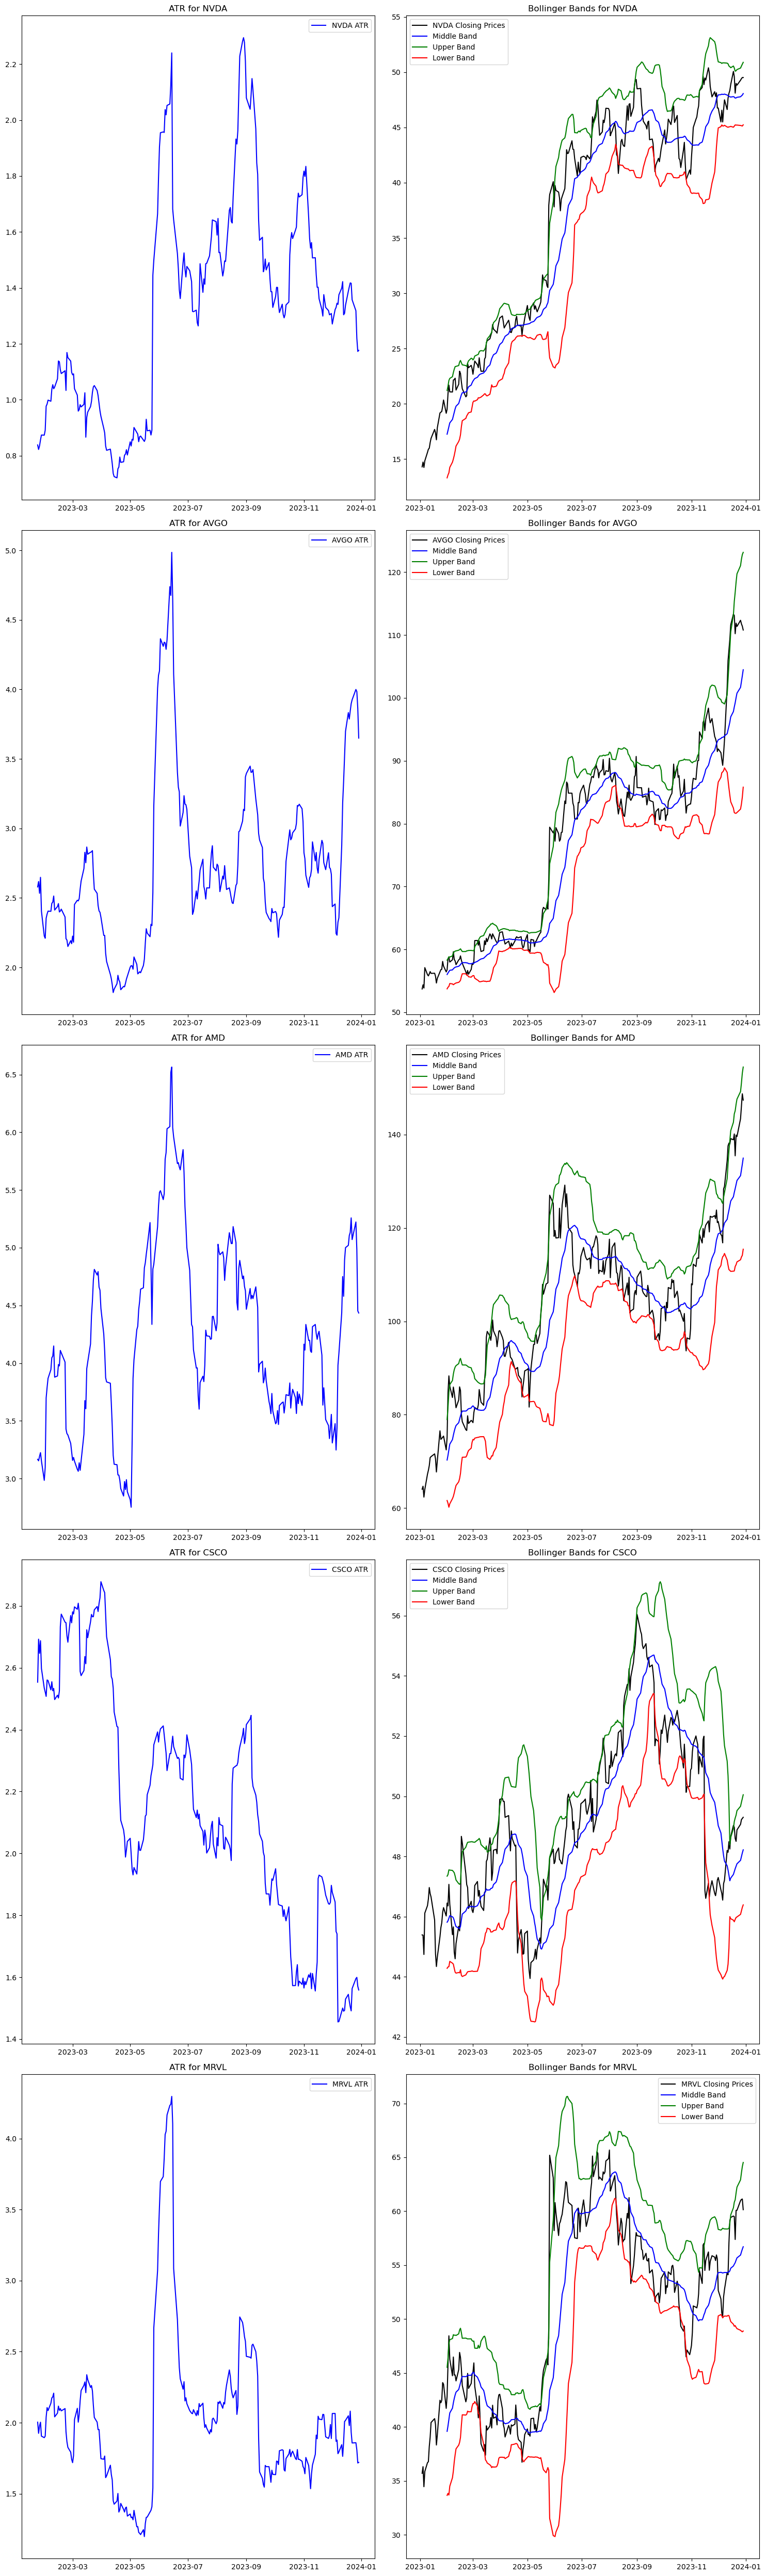

In [167]:
# Visualizing the ATR and Bollinger Bands
plt.figure(figsize=(15, num_stocks * 10))

for i, stock in enumerate(stocks):
    # ATR Plot
    plt.subplot(num_stocks, 2, 2*i+1)
    plt.plot(atrs[stock], label=f'{stock} ATR', color='blue')
    plt.title(f'ATR for {stock}')
    plt.legend()

    # Bollinger Bands Plot
    plt.subplot(num_stocks, 2, 2*i+2)
    plt.plot(closing_prices[stock], label=f'{stock} Closing Prices', color='black')
    plt.plot(bollinger_bands[stock][0], label='Middle Band', color='blue')
    plt.plot(bollinger_bands[stock][1], label='Upper Band', color='green')
    plt.plot(bollinger_bands[stock][2], label='Lower Band', color='red')
    plt.title(f'Bollinger Bands for {stock}')
    plt.legend()

plt.tight_layout()
plt.show()

### 4.7 RSI 

**Relative Strength Index**
- The RSI is a momentum oscillator that measures the speed and change of price movements. 
- It is typically used to identify overbought or oversold conditions in a traded asset.
- RSI Interpretation: 
    - Typical thresholds are 70 (overbought) and 30 (oversold). 
    - Values exceeding these thresholds might indicate a potential reversal or correction in price.

In [172]:
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [174]:
# Calculate RSI for each stock
rsi_results = {}
for stock in stocks:
    rsi_results[stock] = RSI(closing_prices[stock])

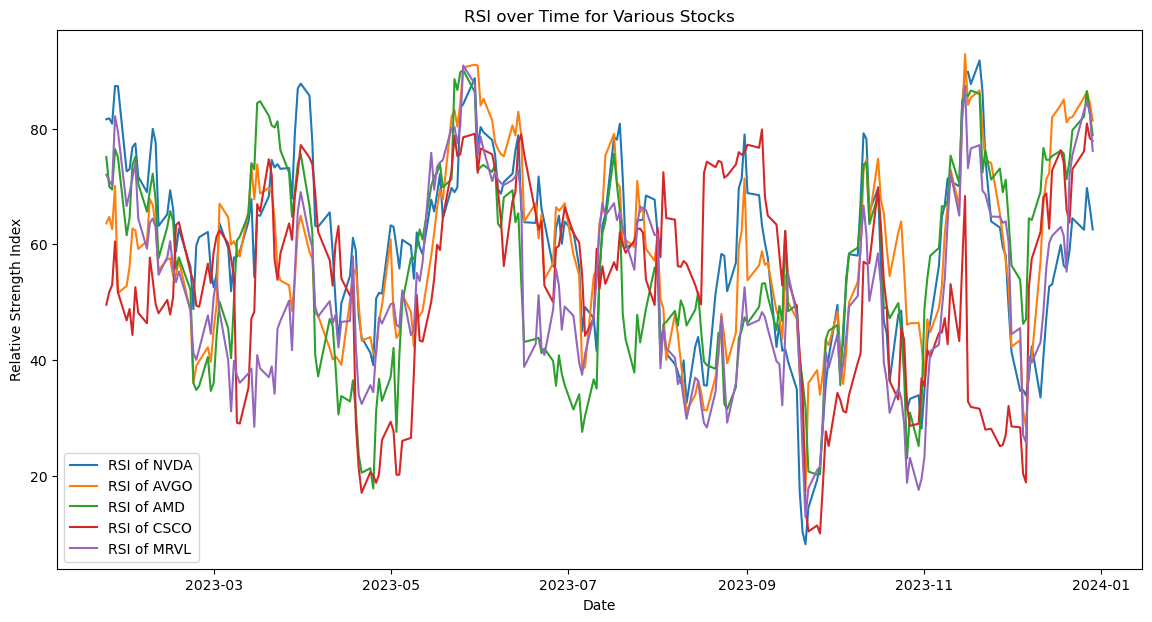

In [176]:
# Plot RSI for each stock
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(rsi_results[stock], label=f'RSI of {stock}')

plt.title('RSI over Time for Various Stocks')
plt.xlabel('Date')
plt.ylabel('Relative Strength Index')
plt.legend()
plt.show()

### 4.8 ADX 

**Average Directional Index**
- The ADX is used to measure the strength of a trend, not its direction. 
- It is derived from two other indicators, the Positive Directional Indicator (+DI) and the Negative Directional Indicator (-DI), which themselves are derived from the Directional Movement Index (DMI).

**ADX Values and Their Interpretations**

- **0 to 100 Range**: ADX values typically range from 0 to 100, with values above 50 being quite rare.
  - **Below 20**: Generally indicates a weak trend or the absence of a trend.
  - **20 to 25**: Represents a zone where trend strength is considered questionable or marginal.
  - **Above 25**: Suggests a strong trend, making trend-following strategies more likely to succeed.
  - **Above 40**: Indicates a very strong trend.

**Directional Indicators (+DI and -DI)**

These indicators help determine the direction of the trend:
- **+DI above -DI**: Suggests that the trend is upwards.
- **-DI above +DI**: Indicates that the trend is downwards.

**Practical Usage of ADX**

1. **Trend Confirmation**:
   - **Long Position**: If considering a long position and the ADX is above 25 with +DI above -DI, it supports the decision to go long.
   - **Short Position**: If considering a short position and the ADX is above 25 with -DI above +DI, it supports the decision to go short.

2. **Avoid Trades in Weak Trends**:
   - When the ADX is below 20, it's often advisable to avoid trend-following trades because the market might be in a consolidation phase, where prices move sideways without any clear direction.

3. **Trend Strength and Changes**:
   - An **increasing ADX** indicates that the trend is getting stronger.
   - A **decreasing ADX** suggests the trend is weakening, which might indicate a range-bound market or the start of a trend reversal.


In [207]:
def calculate_DI_and_ADX(df, n=14):
    delta_high = df['High'].diff(1)
    delta_low = df['Low'].diff(1)

    plus_dm = pd.Series(np.where((delta_high > delta_low) & (delta_high > 0), delta_high, 0.0), index=df.index)
    minus_dm = pd.Series(np.where((delta_low > delta_high) & (delta_low > 0), delta_low, 0.0), index=df.index)

    tr1 = pd.DataFrame(df['High'] - df['Low'])
    tr2 = pd.DataFrame(abs(df['High'] - df['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(df['Low'] - df['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1).max(axis=1)
    
    atr = tr.rolling(window=n).mean()

    plus_di = 100 * (plus_dm.rolling(window=n).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(window=n).sum() / atr)

    di_diff = abs(plus_di - minus_di)
    di_sum = plus_di + minus_di

    dx = 100 * (di_diff / di_sum)
    adx = dx.rolling(window=n).mean()

    return plus_di, minus_di, adx

In [211]:
# Dictionary to store ADX results
adx_results = {}

# Loop through each stock to calculate ADX
for stock in stocks:
    try:
        # Extract the relevant market data for the stock
        stock_data = data.loc[:, (slice(None), stock)]
        stock_data.columns = stock_data.columns.droplevel(1)  # Drop the stock level

        # Debug print to check the dataframe structure
        print(f"Data for {stock}:")
        print(stock_data.head())

        # Calculate ADX
        plus_di, minus_di, adx = calculate_DI_and_ADX(stock_data)
        adx_results[stock] = adx
    except KeyError as e:
        print(f"An error occurred with {stock}: {e}")

Data for NVDA:
Price                      Adj Close   Close    High     Low    Open  \
Date                                                                   
2023-01-03 00:00:00+00:00  14.305581  14.315  14.996  14.096  14.851   
2023-01-04 00:00:00+00:00  14.739295  14.749  14.853  14.241  14.567   
2023-01-05 00:00:00+00:00  14.255614  14.265  14.564  14.148  14.491   
2023-01-06 00:00:00+00:00  14.849224  14.859  15.010  14.034  14.474   
2023-01-09 00:00:00+00:00  15.617718  15.628  16.056  15.141  15.284   

Price                         Volume  
Date                                  
2023-01-03 00:00:00+00:00  401277000  
2023-01-04 00:00:00+00:00  431324000  
2023-01-05 00:00:00+00:00  389168000  
2023-01-06 00:00:00+00:00  405044000  
2023-01-09 00:00:00+00:00  504231000  
Data for AVGO:
Price                      Adj Close      Close       High        Low  \
Date                                                                    
2023-01-03 00:00:00+00:00  53.716278  55.34800

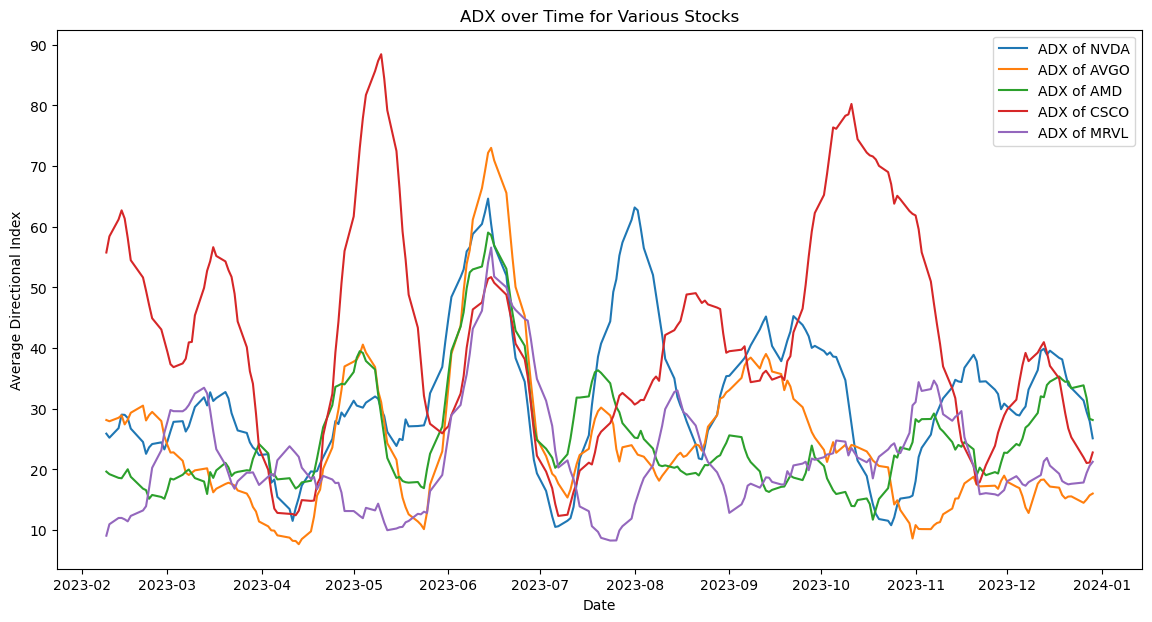

In [213]:
# Plot ADX for each stock
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(adx_results[stock], label=f'ADX of {stock}')

plt.title('ADX over Time for Various Stocks')
plt.xlabel('Date')
plt.ylabel('Average Directional Index')
plt.legend()
plt.show()

### 4.9 Renko 

Renko charts are a type of price charting that help traders to more clearly see the price trends by filtering out smaller price movements. 

**Interpreting Trends and Reversals**
- Trends: A series of bricks in the same color suggests a strong trend. More consecutive bricks of the same color (up or down) typically indicate a stronger trend.
- Reversals: 
    - A reversal occurs when two bricks of opposite color appear, indicating a potential change in direction. 
    - The minimum price movement for a reversal is typically twice the brick size (because a new brick in the opposite direction cannot form next to a brick of the same direction—it must skip one brick's width).

In [ ]:
!pip install mplfinance

In [219]:
import mplfinance as mpf

In [ ]:
def renko_chart(stock_symbol, start_date, end_date, brick_size='atr', atr_length=14):
    """
    Generates a Renko chart for the given stock symbol over the specified date range.
    
    Parameters:
        stock_symbol (str): The ticker symbol for the stock.
        start_date (str): Start date for the data in 'YYYY-MM-DD' format.
        end_date (str): End date for the data in 'YYYY-MM-DD' format.
        brick_size (str or float): Size of each brick. Use 'atr' for average true range or specify a fixed size.
        atr_length (int): The period to calculate ATR if brick_size is 'atr'.
    """
    # Fetch historical data
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    
    # Check available styles and use a valid one
    available_styles = plt.style.available
    base_style = 'seaborn-darkgrid' if 'seaborn-darkgrid' in available_styles else available_styles[0]
    
    # Configure the style and properties of the Renko chart
    mpf_style = mpf.make_mpf_style(base_mpl_style=base_style, rc={'figure.facecolor': 'lightgray'})
    
    # Define Renko parameters
    renko_kwargs = {
        'brick_size': brick_size,
        'atr_length': atr_length
    }
    
    # Plotting the Renko chart
    mpf.plot(data, type='renko', renko_params=renko_kwargs, style=mpf_style, title=f'Renko Chart for {stock_symbol}')


[*********************100%***********************]  1 of 1 completed


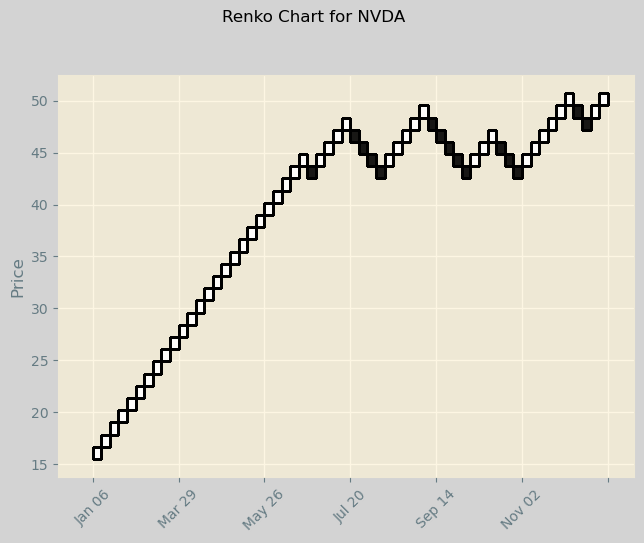

[*********************100%***********************]  1 of 1 completed


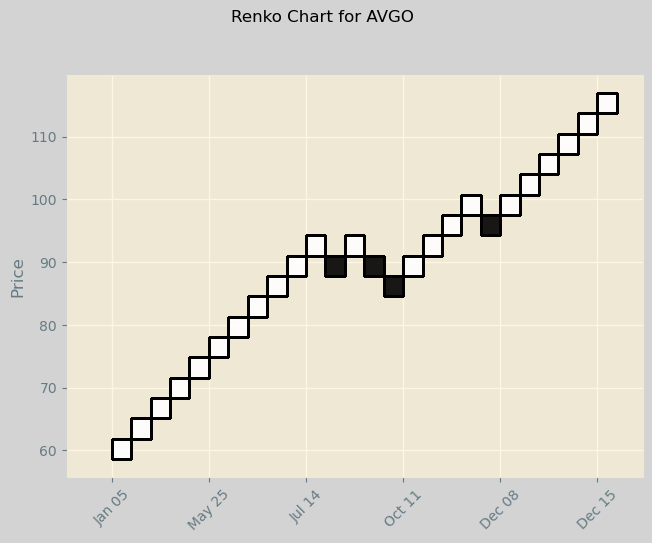

[*********************100%***********************]  1 of 1 completed


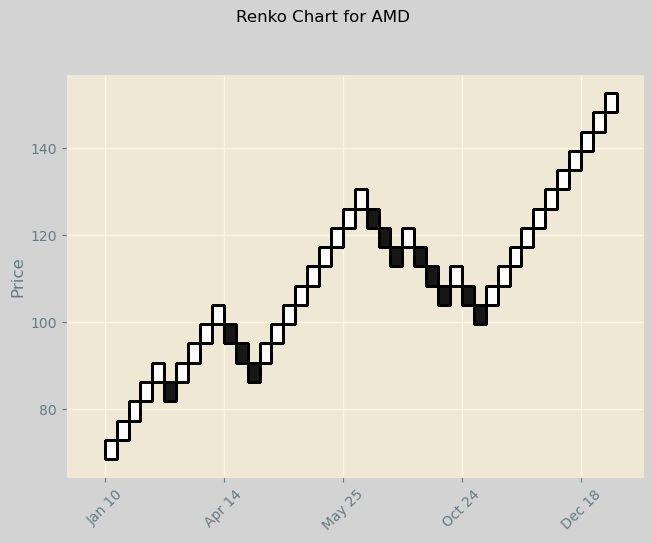

[*********************100%***********************]  1 of 1 completed


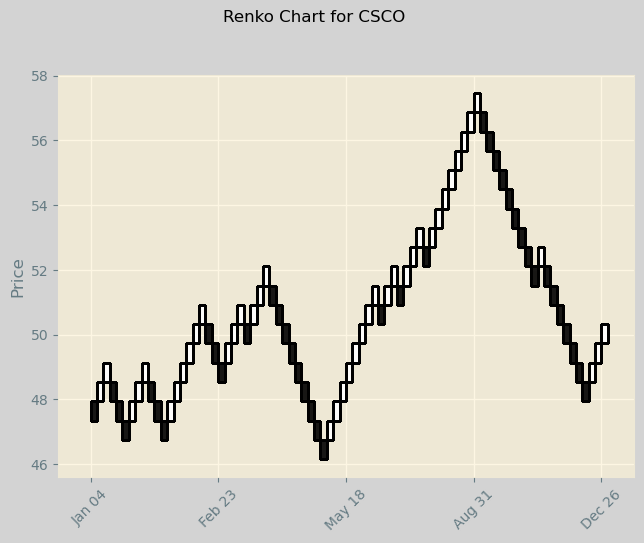

[*********************100%***********************]  1 of 1 completed


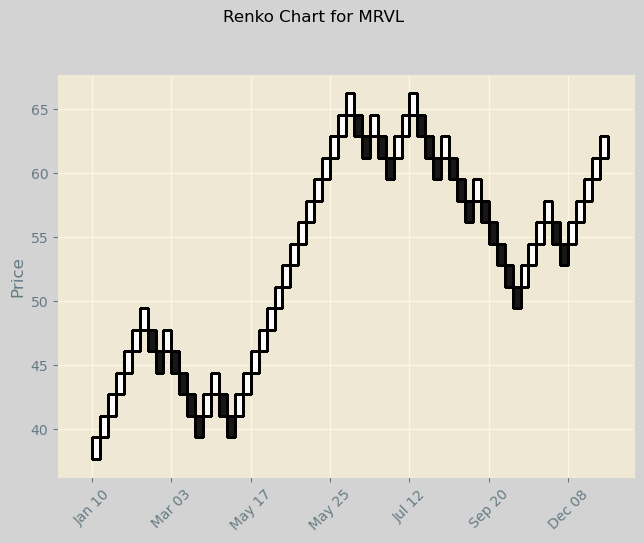

In [225]:
for stock in stocks:
    renko_chart(stock, '2023-01-01', '2023-12-31')

## Step 5: Performance Measurement - KPIs

### 5.1 CAGR

In [236]:
# Download historical data for required stocks
tickers = ["NVDA", "AVGO", "AMD", "CSCO", "MRVL"]

ohlcv_data = {}

# looping over tickers and storing OHLCV dataframe in dictionary
for ticker in tickers:
    temp = yf.download(ticker,period='6mo',interval='1d')
    temp.dropna(how="any",inplace=True)
    ohlcv_data[ticker] = temp

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["return"] = DF["Adj Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    n = len(df)/252
    CAGR = (df["cum_return"].iloc[-1])**(1/n) - 1
    return CAGR

for ticker in ohlcv_data:
    print("CAGR of {} = {}".format(ticker,CAGR(ohlcv_data[ticker])))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

CAGR of NVDA = 0.8259189600154613
CAGR of AVGO = 0.7830413296734198
CAGR of AMD = -0.3348792068843205
CAGR of CSCO = 0.034037269399280534
CAGR of MRVL = 0.27221836199384053


### 5.2 Sharpe Ratio & Sortino Ratio

- Sharpe Ratio: Measures the excess return per unit of deviation in an investment. It considers both the upside and downside volatility as general risk.
- Sortino Ratio: Similar to the Sharpe ratio but differentiates harmful volatility from total overall volatility by focusing only on the downside deviation.

In [242]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    df["return"] = df["Adj Close"].pct_change()
    vol = df["return"].std() * np.sqrt(252)
    return vol

def sharpe(DF, rf):
    "function to calculate Sharpe Ratio of a trading strategy"
    df = DF.copy()
    return (CAGR(df) - rf)/volatility(df)

def sortino(DF, rf):
    "function to calculate Sortino Ratio of a trading strategy"
    df = DF.copy()
    df["return"] = df["Adj Close"].pct_change()
    neg_return = np.where(df["return"]>0,0,df["return"])
    #below you will see two ways to calculate the denominator (neg_vol), some people use the
    #standard deviation of negative returns while others use a downward deviation approach,
    #you can use either. However, downward deviation approach is more widely used
    neg_vol = np.sqrt((pd.Series(neg_return[neg_return != 0]) ** 2).mean() * 252)
    #neg_vol = pd.Series(neg_return[neg_return != 0]).std() * np.sqrt(252)
    return (CAGR(df) - rf)/neg_vol

for ticker in ohlcv_data:
    print("Sharpe of {} = {}".format(ticker,sharpe(ohlcv_data[ticker],0.03)))
    print("Sortino of {} = {}".format(ticker,sortino(ohlcv_data[ticker],0.03)))

Sharpe of NVDA = 1.3487689391009063
Sortino of NVDA = 1.3747472589426961
Sharpe of AVGO = 1.404501187183637
Sortino of AVGO = 1.4962188253077633
Sharpe of AMD = -0.7626909584743552
Sortino of AMD = -0.6871117652960466
Sharpe of CSCO = 0.020274697212945506
Sortino of CSCO = 0.02112860255848801
Sharpe of MRVL = 0.4543766635832538
Sortino of MRVL = 0.44157364882430816


**NVIDIA (NVDA)**
- Sharpe Ratio: 1.3488
- Sortino Ratio: 1.3747
- Interpretation: NVDA's ratios suggest it offers good returns compared to the risk taken, with a high reward per unit of total risk and even higher when considering only downside risk. The proximity of the Sharpe and Sortino ratios indicates that the downside risk isn’t drastically different from the overall volatility.

**Broadcom (AVGO)**
- Sharpe Ratio: 1.4045
- Sortino Ratio: 1.4962
- Interpretation: AVGO shows a strong performance with higher returns per unit of risk. Its Sortino ratio being higher than the Sharpe ratio suggests that the negative returns are less volatile and thus less significant than the total volatility, indicating efficient management of downside risks.

**AMD**
- Sharpe Ratio: -0.7627
- Sortino Ratio: -0.6871
- Interpretation: AMD’s negative ratios indicate poor performance, with negative returns relative to the risk taken. The Sortino ratio being less negative than the Sharpe ratio suggests that the downside risk is somewhat lower than the overall risk, but still, the investment has underperformed.

**Cisco Systems (CSCO)**
- Sharpe Ratio: 0.0203
- Sortino Ratio: 0.0211
- Interpretation: CSCO’s very low ratios indicate that it offers almost no excess return over the risk-free rate, with negligible compensation for the risks undertaken. Both ratios being nearly the same suggests that the downside risks are proportional to the overall risks.

**Marvell Technology (MRVL)**
- Sharpe Ratio: 0.4544
- Sortino Ratio: 0.4416
- Interpretation: MRVL has moderate ratios, suggesting a moderate reward relative to the risks. The very close values of the Sharpe and Sortino ratios indicate that the investment experiences similar magnitudes of total and downside volatility.

### 5.3 Maximum Drawdown & Calmar Ratio

#### Max Drawdown
- **Definition:** The maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. It is an indicator of downside risk over a specified time period.
- **Interpretation:** Higher values indicate larger drops in value and potentially higher risk, whereas lower values indicate less severe drops.

#### Calmar Ratio
- **Definition:** The Calmar ratio is a performance metric that calculates the average annual compounded rate of return divided by the maximum drawdown in the same period. It measures an investment's performance relative to its downside risk.
- **Interpretation:** Higher values are better, indicating that the investment has yielded good returns in relation to the risk of large losses. A negative Calmar ratio indicates that the investment has a negative average annual return.

In [247]:
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["return"] = df["Adj Close"].pct_change()
    df["cum_return"] = (1+df["return"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    return (df["drawdown"]/df["cum_roll_max"]).max()
    
def calmar(DF):
    "function to calculate calmar ratio"
    df = DF.copy()
    return CAGR(df)/max_dd(df)

for ticker in ohlcv_data:
    print("max drawdown of {} = {}".format(ticker,max_dd(ohlcv_data[ticker])))
    print("calmar ratio of {} = {}".format(ticker,calmar(ohlcv_data[ticker])))

max drawdown of NVDA = 0.27046760966799843
calmar ratio of NVDA = 3.053670496919334
max drawdown of AVGO = 0.2525290967064578
calmar ratio of AVGO = 3.100796462213756
max drawdown of AMD = 0.32654663554318814
calmar ratio of AMD = -1.0255172475664056
max drawdown of CSCO = 0.09771449096935331
calmar ratio of CSCO = 0.3483338966577211
max drawdown of MRVL = 0.2825646381635379
calmar ratio of MRVL = 0.9633843914902426


#### NVIDIA (NVDA)
- **Max Drawdown:** 27.05%
- **Calmar Ratio:** 3.054
  - **Interpretation:** NVDA has experienced a significant drawdown, yet it maintains a high Calmar ratio, indicating strong annual performance relative to its worst-case scenario loss. This suggests resilience and strong recovery characteristics.

#### Broadcom (AVGO)
- **Max Drawdown:** 25.25%
- **Calmar Ratio:** 3.101
  - **Interpretation:** Similar to NVDA, AVGO shows a substantial drawdown but an even slightly higher Calmar ratio, reflecting very efficient recovery and strong annual returns relative to its peak-to-trough decline.

#### AMD
- **Max Drawdown:** 32.65%
- **Calmar Ratio:** -1.026
  - **Interpretation:** AMD exhibits the largest drawdown among the discussed stocks and a negative Calmar ratio, indicating that it has failed to generate positive annual returns over this period. This suggests significant risk and poor performance.

#### Cisco Systems (CSCO)
- **Max Drawdown:** 9.77%
- **Calmar Ratio:** 0.348
  - **Interpretation:** CSCO has the lowest max drawdown, indicating smaller declines, but its Calmar ratio is also low, suggesting modest annual returns in relation to the drawdown. This points to a conservative investment with low risk and low reward characteristics.

#### Marvell Technology (MRVL)
- **Max Drawdown:** 28.26%
- **Calmar Ratio:** 0.963
  - **Interpretation:** MRVL’s significant drawdown is coupled with a moderate Calmar ratio. It indicates better performance relative to its risk of loss compared to AMD but less impressive than NVDA or AVGO.

### Conclusion

The max drawdown and Calmar ratio combined offer a nuanced view of investment risk and performance:
- **High Calmar Ratio** (such as NVDA and AVGO) suggests strong performance despite significant potential declines, appealing to those who can tolerate temporary losses for higher returns.
- **Low or Negative Calmar Ratio** (such as AMD and CSCO) indicates either inadequate compensation for risks taken (CSCO) or poor performance (AMD), which might be unappealing unless specific circumstances or strategies justify such investments.
- **Moderate Calmar Ratio** (MRVL) reflects a balanced, albeit cautious, investment posture between risk and return.